## Project summary

__Models__
- Mean model used as a baseline
- Concatenated model
- Dot product model

Further testing done by adding additional 2 continuous data features - average user score and metacritics score

In [1]:
%load_ext autoreload
%load_ext lab_black
%autoreload 2

In [2]:
from gpu_helper import enable_gpu

enable_gpu()

PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')
1 Physical GPUs, 1 Logical GPUs


In [212]:
from toai.imports import *
import tensorflow as tf
from tensorflow import keras
from model_utils import show_history

In [4]:
DATA_DIR = Path("data")
TEMP_DIR = Path("temp")
DATA_DIR.mkdir(parents=True, exist_ok=True)
TEMP_DIR.mkdir(parents=True, exist_ok=True)

In [5]:
df_game_info = pd.read_csv(DATA_DIR / "metacritic_game_info.csv")
df_game_info.drop(["Unnamed: 0"], axis=1, inplace=True)
df_game_comments = pd.read_csv(DATA_DIR / "metacritic_game_user_comments.csv")
df_game_comments.drop(["Unnamed: 0", "Comment"], axis=1, inplace=True)

In [6]:
df_game_comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 283983 entries, 0 to 283982
Data columns (total 4 columns):
Title        283983 non-null object
Platform     283983 non-null object
Userscore    283983 non-null int64
Username     283980 non-null object
dtypes: int64(1), object(3)
memory usage: 8.7+ MB


In [7]:
df_game_comments = df_game_comments[
    df_game_comments.groupby("Username")["Username"].transform("size") >= 5
]

In [8]:
df_game_comments = df_game_comments.loc[
    ~df_game_comments["Username"].isin(["AnonymousMC", "[Anonymous]"]), :
].reset_index(drop=True)

In [9]:
df_game_comments["Username"].value_counts()

Broyax            274
iddqd4            255
SuperkenGaming    230
drlowdon          216
TheQuietGamer     211
                 ... 
Jhango1             5
JamesA              5
Jugalator           5
SimonT.             5
breezy808           5
Name: Username, Length: 10231, dtype: int64

In [10]:
df_game_comments.head()

,Title,Platform,Userscore,Username
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,doodlerman
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,StevenA
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Nosidda89
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,KendylKlownfish
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Bolts


In [11]:
df_game_info.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player


In [12]:
df_game_info["Title"].value_counts()

Madden NFL 07                      7
This page isn’t working            6
Tony Hawk's Pro Skater 3           6
Marvel: Ultimate Alliance          6
Rayman Legends                     5
                                  ..
Grandia                            1
The House of the Dead: Overkill    1
Mega Man Zero Collection           1
DEFCON: Everybody Dies             1
Need for Speed: Carbon             1
Name: Title, Length: 3438, dtype: int64

Same game might have different titles but for different plaforms. We need to uniquely identify the game.

In [13]:
df_game_info[df_game_info["Title"] == "Madden NFL 07"]

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
1880,Madden NFL 07,2006,EASports,Sports;Traditional;Football;Sim,PlayStation2,84,8.2,1-2
2206,Madden NFL 07,2006,EATiburon,Sports;Traditional;Football;Sim,Xbox,83,8.7,1-4
2531,Madden NFL 07,2006,EATiburon,Sports;Traditional;Football;Sim,GameCube,82,7.8,2 Online
3125,Madden NFL 07,2006,EACanada,Sports;Traditional;Team;Football;Sim;Sim,Wii,81,8.0,No Online Multiplayer
3360,Madden NFL 07,2006,EATiburon,Sports;Traditional;Team;Football;Sim;Sim,Xbox360,80,6.0,2 Online
3428,Madden NFL 07,2006,EATiburon,Sports;Traditional;Team;Football;Sim;Sim,PC,80,7.3,2 Online
4388,Madden NFL 07,2006,EATiburon,Sports;Traditional;Team;Football;Sim;Sim,PSP,78,6.6,1-2


In [14]:
def create_game_ids(df):
    """Return dictionary of game titles for specific plaform mapped to unique ID"""

    game_ids = {}
    for idx, key in enumerate(
        np.unique((df["Title"] + " for " + df["Platform"]).values)
    ):
        game_ids[key] = idx

    return game_ids


def apply_game_ids(df, game_ids):
    df["GameID"] = df.apply(
        lambda x: game_ids[(x["Title"] + " for " + x["Platform"])], axis=1
    )

    return df

In [15]:
game_ids = create_game_ids(df_game_info)
df_game_info = apply_game_ids(df_game_info, game_ids)

In [16]:
df_game_info.head()

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,GameID
0,The Legend of Zelda: Ocarina of Time,1998,Nintendo,Action Adventure;Fantasy,Nintendo64,99,9.1,1 Player,4209
1,Tony Hawk's Pro Skater 2,2000,NeversoftEntertainment,Sports;Alternative;Skateboarding,PlayStation,98,7.4,1-2,4535
2,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,PlayStation3,98,7.5,1 Player,1612
3,SoulCalibur,1999,Namco,Action;Fighting;3D,Dreamcast,98,8.6,1-2,3725
4,Grand Theft Auto IV,2008,RockstarNorth,Action Adventure;Modern;Modern;Open-World,Xbox360,98,7.9,1 Player,1613


In [17]:
len(df_game_info), len(np.unique(df_game_info["GameID"]))

(5000, 4993)

In [18]:
df_game_info["GameID"].value_counts()

4391    6
205     3
2047    1
557     1
549     1
       ..
3263    1
1218    1
3267    1
1222    1
0       1
Name: GameID, Length: 4993, dtype: int64

It appears we still have some duplicates

In [19]:
df_game_info[df_game_info["GameID"].isin([4391, 205])]

,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players,GameID
1360,Bad Request,not specified,not specified,no genre,not specified,not specified,not specified,not specified,205
2122,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2123,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2124,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2125,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2126,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
2127,This page isn’t working,not specified,not specified,no genre,not specified,not specified,not specified,not specified,4391
4408,Bad Request,not specified,not specified,no genre,not specified,not specified,not specified,not specified,205
4434,Bad Request,not specified,not specified,no genre,not specified,not specified,not specified,not specified,205


In [20]:
df_game_info = df_game_info.loc[
    ~df_game_info["GameID"].isin([4391, 205]), :
].reset_index(drop=True)

In [21]:
len(df_game_info), len(np.unique(df_game_info["GameID"]))

(4991, 4991)

In [22]:
df_game_comments = apply_game_ids(df_game_comments, game_ids)

In [23]:
df_game_comments["UserID"] = df_game_comments.groupby("Username").ngroup()

In [24]:
df_game_comments.head()

,Title,Platform,Userscore,Username,GameID,UserID
0,The Legend of Zelda: Ocarina of Time,Nintendo64,10,doodlerman,4209,7976
1,The Legend of Zelda: Ocarina of Time,Nintendo64,10,StevenA,4209,6221
2,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Nosidda89,4209,4864
3,The Legend of Zelda: Ocarina of Time,Nintendo64,10,KendylKlownfish,4209,3634
4,The Legend of Zelda: Ocarina of Time,Nintendo64,10,Bolts,4209,818


In [25]:
df = df_game_comments.drop(["Title", "Platform", "Username"], axis=1)

In [26]:
df = df.merge(df_game_info, left_on="GameID", right_on="GameID")

In [27]:
remove_by_metascore = df[df["Metascore"] == "not specified"]["GameID"].values
df[df["Metascore"] == "not specified"]

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
56092,10,1126,7739,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56093,9,1126,1202,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56094,10,1126,4040,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56095,5,1126,2215,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56096,9,1126,4634,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56097,6,1126,9103,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified


In [28]:
remove_by_avg_score = df[df["Avg_Userscore"].isin(["tbd", "not specified"])][
    "GameID"
].values
df[df["Avg_Userscore"].isin(["tbd", "not specified"])]

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
40432,9,2240,140,Madden NFL 2005,2004,EATiburon,Sports;Traditional;Football;Sim,GameCube,90,tbd,1-4
56092,10,1126,7739,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56093,9,1126,1202,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56094,10,1126,4040,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
56095,5,1126,2215,Error 503 Service Unavailable,not specified,not specified,no genre,not specified,not specified,not specified,not specified
...,...,...,...,...,...,...,...,...,...,...,...
100972,9,2571,1609,NASCAR Thunder 2002,2001,EATiburon,Driving;Racing;Stock Car,Xbox,82,tbd,1-4
103258,10,2687,6194,NCAA March Madness 2004,2003,EASports,Sports;Traditional;Basketball;Sim,Xbox,81,tbd,1-4
107600,8,4405,372,Tiger Woods PGA Tour 07,2006,EARedwoodShores,Sports;Traditional;Individual;Golf;Sim;Sim,PlayStation3,81,tbd,Up to 4
110041,8,2127,7151,Lumines Remastered,2018,EnhanceGames,Puzzle;Matching,XboxOne,81,tbd,No Online Multiplayer


In [29]:
df = df.loc[
    ~df["GameID"].isin(np.append(remove_by_metascore, remove_by_avg_score)), :
].reset_index(drop=True)

In [30]:
df["Metascore"] = df["Metascore"].astype("int32")
df["Avg_Userscore"] = df["Avg_Userscore"].astype("float64")

In [31]:
df.describe()

,Userscore,GameID,UserID,Metascore,Avg_Userscore
count,112371.000000,112371.000000,112371.000000,112371.000000,112371.000000
mean,7.911943,2310.923761,5129.801034,87.958931,7.971631
std,2.579331,1481.949997,2969.246196,4.724206,1.092781
min,0.000000,0.000000,0.000000,80.000000,1.600000
25%,7.000000,960.000000,2549.000000,84.000000,7.600000
50%,9.000000,2097.000000,5141.000000,88.000000,8.300000
75%,10.000000,3730.000000,7702.000000,92.000000,8.700000
max,10.000000,4989.000000,10230.000000,99.000000,9.300000


In [32]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 112371 entries, 0 to 112370
Data columns (total 11 columns):
Userscore        112371 non-null int64
GameID           112371 non-null int64
UserID           112371 non-null int64
Title            112371 non-null object
Year             112371 non-null object
Publisher        112371 non-null object
Genre            112371 non-null object
Platform         112371 non-null object
Metascore        112371 non-null int32
Avg_Userscore    112371 non-null float64
No_Players       112317 non-null object
dtypes: float64(1), int32(1), int64(3), object(6)
memory usage: 9.0+ MB


In [33]:
target_col = "Userscore"

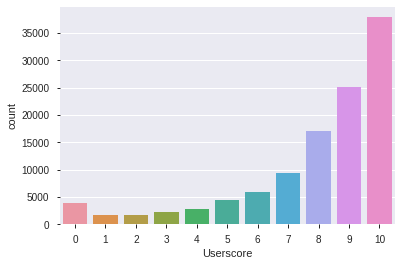

In [34]:
sns.countplot(x=target_col, data=df)

## Split into train, validation and test datasets

In [35]:
from toai.data.utils import split_df

In [36]:
train_df, val_df, test_df = split_df(df, 0.2)

In [37]:
[x.shape for x in (train_df, val_df, test_df)]

[(89896, 11), (11237, 11), (11238, 11)]

## Processing

In [38]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [39]:
scaler.fit(train_df[[target_col]])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [40]:
train_df[target_col] = scaler.transform(train_df[[target_col]])

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [41]:
val_df[target_col] = scaler.transform(val_df[[target_col]])

In [42]:
train_df.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,1.0,1969,7571,Kingdoms of Amalur: Reckoning,2012,BigHugeGames,Role-Playing;PC-style RPG;Action RPG,PlayStation3,81,7.7,No Online Multiplayer
1,0.8,2437,6679,Metroid: Samus Returns,2017,MercurySteam,Action Adventure;Open-World,3DS,85,8.9,No Online Multiplayer
2,0.8,718,4650,DOOM,2016,idSoftware,Sci-Fi;Action;Shooter;First-Person;Third-Perso...,XboxOne,87,8.4,Up to 12
3,1.0,1714,2123,Halo 4,2012,343Industries,Shooter;Sci-Fi;Sci-Fi;Action;Shooter;First-Per...,Xbox360,87,7.0,Up to 16
4,1.0,1379,9287,Final Fantasy VII,1997,SquareSoft,Role-Playing;Console-style RPG,PlayStation,92,9.2,1 Player


In [43]:
train_df[target_col][:10].values

array([1. , 0.8, 0.8, 1. , 1. , 0.5, 1. , 1. , 0.7, 1. ])

In [44]:
scaler.inverse_transform(train_df[[target_col]][:10]).flatten()

array([10.,  8.,  8., 10., 10.,  5., 10., 10.,  7., 10.])

In [45]:
BATCH_SIZE = 512
AUTOTUNE = tf.data.experimental.AUTOTUNE

In [46]:
train_df["UserID"].max(), val_df["UserID"].max(), train_df["GameID"].max(), val_df[
    "GameID"
].max()

(10230, 10230, 4989, 4989)

In [47]:
train_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (train_df["UserID"].values, train_df["GameID"].values)
            ),
            tf.data.Dataset.from_tensor_slices(train_df[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [48]:
val_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (val_df["UserID"].values, val_df["GameID"].values)
            ),
            tf.data.Dataset.from_tensor_slices(val_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [49]:
train_data_steps = len(train_df) // BATCH_SIZE
n_users = 11000
n_games = 5000

In [214]:
class EmbeddingLayer:
    def __init__(self, input_dim: int, embedding_dim: int):
        self.input_dim = input_dim
        self.embedding_dim = embedding_dim

    def __call__(self, layer: keras.layers.Layer) -> keras.layers.Layer:
        layer = keras.layers.Embedding(
            self.input_dim, self.embedding_dim, input_length=(1,)
        )(layer)
        return keras.layers.Flatten()(layer)

In [219]:
def make_concat_model(
    user_dim,
    item_dim,
    embedding_dim,
    layer_size=256,
    dropout_rate=0.0,
    regularization=None,
):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    x = keras.layers.Concatenate()(
        [user_embedding, user_bias, item_embedding, item_bias]
    )
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(
        layer_size,
        kernel_initializer=keras.initializers.he_uniform(),
        kernel_regularizer=regularization and keras.regularizers.l1_l2(*regularization),
    )(x)
    x = keras.layers.LeakyReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    x = keras.layers.Dropout(dropout_rate)(x)
    x = keras.layers.Dense(1)(x)
    outputs = keras.layers.Activation(keras.activations.sigmoid)(x)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [221]:
concat_model = make_concat_model(
    n_users, n_games, 128, layer_size=512, dropout_rate=0.3, regularization=(1e-8, 1e-4)
)

In [52]:
concat_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [53]:
PATIENCE = 5

concat_model_history = concat_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

(None, None)

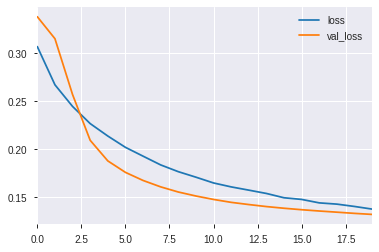

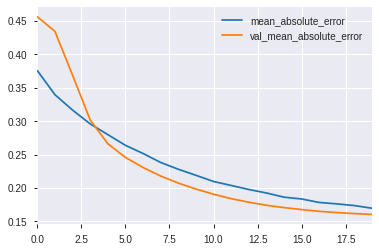

In [54]:
show_history(concat_model_history, "loss"), show_history(concat_model_history, "err")

In [215]:
def make_dot_model(user_dim, item_dim, embedding_dim):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = EmbeddingLayer(user_dim, embedding_dim)(user_input)
    user_bias = EmbeddingLayer(user_dim, 1)(user_input)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = EmbeddingLayer(item_dim, embedding_dim)(item_input)
    item_bias = EmbeddingLayer(item_dim, 1)(item_input)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input], outputs=outputs)
    return model

In [218]:
dot_model = make_dot_model(n_users, n_games, 128)

In [217]:
dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [113]:
PATIENCE = 5

dot_model_history = dot_model.fit(
    train_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_dataset,
    epochs=20,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=0,
)

(None, None)

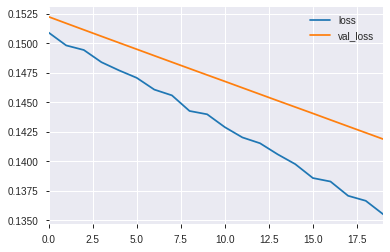

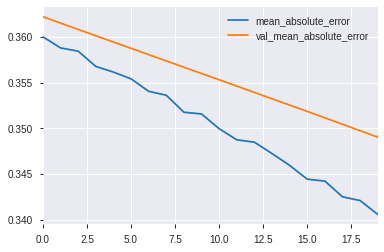

In [114]:
show_history(dot_model_history, "loss"), show_history(dot_model_history, "err")

In [60]:
class MeanModel(keras.Model):
    def __init__(self, mean):
        super().__init__()
        self.mean = tf.constant(mean, dtype=tf.float32)

    def call(self, inputs):
        return tf.ones_like(inputs[0], dtype=tf.float32) * self.mean

In [61]:
mean_model = MeanModel(train_df[target_col].mean())

In [62]:
mean_model.compile(optimizer=keras.optimizers.Adam(3e-4), loss=keras.losses.mse)

In [63]:
mean_model.predict(val_dataset)

array([[0.79109526],
       [0.79109526],
       [0.79109526],
       ...,
       [0.79109526],
       [0.79109526],
       [0.79109526]], dtype=float32)

## Model evaluation

In [67]:
from toai.metrics import rmse

In [68]:
def evaluate_predictions(model, dataset, scaler, metric):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))

    return metric(y_true, y_pred)

In [69]:
for model in [concat_model, dot_model, mean_model]:
    print(evaluate_predictions(model, val_dataset, scaler, rmse))

2.2601890463324703
3.7697290028919053
2.580083232823595


In [70]:
test_df[target_col] = scaler.transform(test_df[[target_col]])

In [73]:
test_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                (test_df["UserID"].values, test_df["GameID"].values)
            ),
            tf.data.Dataset.from_tensor_slices(test_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [74]:
for model in [concat_model, dot_model, mean_model]:
    print(evaluate_predictions(model, test_dataset, scaler, rmse))

2.28503390206077
3.748571107460276
2.594963121637558


## Modeling with additional features

create new datasets

In [147]:
feature_train_df, feature_val_df, feature_test_df = split_df(df, 0.2)

In [148]:
feature_cols = ["Metascore", "Avg_Userscore"]

In [154]:
feature_label_scaler = MinMaxScaler(feature_range=(0, 1))
feature_scaler = MinMaxScaler(feature_range=(0, 1))

In [156]:
feature_label_scaler.fit(feature_train_df[[target_col]])
feature_scaler.fit(feature_train_df[feature_cols])

MinMaxScaler(copy=True, feature_range=(0, 1))

In [158]:
feature_train_df[target_col] = feature_label_scaler.transform(
    feature_train_df[[target_col]]
)
feature_val_df[target_col] = feature_label_scaler.transform(
    feature_val_df[[target_col]]
)

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [159]:
feature_train_df[feature_cols] = feature_scaler.transform(
    feature_train_df[feature_cols]
)
feature_val_df[feature_cols] = feature_scaler.transform(feature_val_df[feature_cols])

/home/martynas/ml/.venv/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/home/martynas/ml/.venv/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [160]:
feature_train_df.head()

,Userscore,GameID,UserID,Title,Year,Publisher,Genre,Platform,Metascore,Avg_Userscore,No_Players
0,1.0,1969,7571,Kingdoms of Amalur: Reckoning,2012,BigHugeGames,Role-Playing;PC-style RPG;Action RPG,PlayStation3,0.052632,0.792208,No Online Multiplayer
1,0.8,2437,6679,Metroid: Samus Returns,2017,MercurySteam,Action Adventure;Open-World,3DS,0.263158,0.948052,No Online Multiplayer
2,0.8,718,4650,DOOM,2016,idSoftware,Sci-Fi;Action;Shooter;First-Person;Third-Perso...,XboxOne,0.368421,0.883117,Up to 12
3,1.0,1714,2123,Halo 4,2012,343Industries,Shooter;Sci-Fi;Sci-Fi;Action;Shooter;First-Per...,Xbox360,0.368421,0.701299,Up to 16
4,1.0,1379,9287,Final Fantasy VII,1997,SquareSoft,Role-Playing;Console-style RPG,PlayStation,0.631579,0.987013,1 Player


In [161]:
train_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [
                        feature_train_df["UserID"].values,
                        feature_train_df["GameID"].values,
                    ]
                    + [feature_train_df[feature_cols].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_train_df[target_col].values),
        )
    )
    .cache()
    .repeat()
    .shuffle(len(feature_train_df))
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [162]:
val_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [feature_val_df["UserID"].values, feature_val_df["GameID"].values]
                    + [feature_val_df[feature_cols].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_val_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [191]:
def make_feature_dot_model(user_dim, item_dim, embedding_dim):
    user_input = keras.layers.Input(shape=(1,))
    user_embedding = keras.layers.Embedding(user_dim, embedding_dim, input_length=1)(
        user_input
    )
    user_embedding = keras.layers.Flatten()(user_embedding)
    user_bias = keras.layers.Embedding(user_dim, 1, input_length=1)(user_input)
    user_bias = keras.layers.Flatten()(user_bias)

    item_input = keras.layers.Input(shape=(1,))
    item_embedding = keras.layers.Embedding(item_dim, embedding_dim, input_length=1)(
        item_input
    )
    item_embedding = keras.layers.Flatten()(item_embedding)
    item_bias = keras.layers.Embedding(item_dim, 1, input_length=1)(item_input)
    item_bias = keras.layers.Flatten()(item_bias)

    feature_input = keras.layers.Input(shape=(2,))
    feature_dense = keras.layers.Dense(1)(feature_input)

    dot_product = keras.layers.Dot(axes=1)([user_embedding, item_embedding])
    logits = keras.layers.Add()([dot_product, user_bias, item_bias, feature_dense])
    outputs = keras.layers.Activation(keras.activations.sigmoid)(logits)

    model = keras.Model(inputs=[user_input, item_input, feature_input], outputs=outputs)
    return model

In [192]:
feature_dot_model = make_feature_dot_model(n_users, n_games, 128)

_Thanks for the help to Dovydas for helping finding error in model creation with additionl input layers._

In [193]:
feature_dot_model.summary()

Model: "model_17"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_53 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_54 (InputLayer)           [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_80 (Embedding)        (None, 1, 128)       1408000     input_53[0][0]                   
__________________________________________________________________________________________________
embedding_82 (Embedding)        (None, 1, 128)       640000      input_54[0][0]                   
___________________________________________________________________________________________

In [194]:
feature_dot_model.compile(
    optimizer=keras.optimizers.Adam(3e-5),
    loss=keras.losses.mse,
    metrics=[keras.metrics.mae],
)

In [195]:
PATIENCE = 5
train_data_steps = len(feature_train_df) // BATCH_SIZE

feature_dot_model_history = feature_dot_model.fit(
    train_feature_dataset,
    steps_per_epoch=train_data_steps,
    validation_data=val_feature_dataset,
    epochs=10,
    callbacks=[
        tf.keras.callbacks.ReduceLROnPlateau(factor=0.3, patience=PATIENCE),
        tf.keras.callbacks.EarlyStopping(
            patience=PATIENCE * 2, restore_best_weights=True
        ),
    ],
    verbose=2,
)

Train for 175 steps, validate for 22 steps
Epoch 1/10
175/175 - 3s - loss: 0.0658 - mean_absolute_error: 0.2141 - val_loss: 0.0660 - val_mean_absolute_error: 0.2146
Epoch 2/10
175/175 - 2s - loss: 0.0654 - mean_absolute_error: 0.2127 - val_loss: 0.0655 - val_mean_absolute_error: 0.2132
Epoch 3/10
175/175 - 2s - loss: 0.0650 - mean_absolute_error: 0.2114 - val_loss: 0.0651 - val_mean_absolute_error: 0.2119
Epoch 4/10
175/175 - 2s - loss: 0.0633 - mean_absolute_error: 0.2082 - val_loss: 0.0647 - val_mean_absolute_error: 0.2105
Epoch 5/10
175/175 - 2s - loss: 0.0640 - mean_absolute_error: 0.2082 - val_loss: 0.0643 - val_mean_absolute_error: 0.2093
Epoch 6/10
175/175 - 2s - loss: 0.0637 - mean_absolute_error: 0.2071 - val_loss: 0.0640 - val_mean_absolute_error: 0.2080
Epoch 7/10
175/175 - 2s - loss: 0.0629 - mean_absolute_error: 0.2053 - val_loss: 0.0637 - val_mean_absolute_error: 0.2069
Epoch 8/10
175/175 - 2s - loss: 0.0626 - mean_absolute_error: 0.2042 - val_loss: 0.0633 - val_mean_abso

In [198]:
def evaluate_feature_predictions(model, dataset, scaler, metric):
    y_true = np.concatenate(
        [scaler.inverse_transform(y.numpy().reshape(-1, 1)) for _, y in dataset]
    )
    y_pred = scaler.inverse_transform(model.predict(dataset))

    return metric(y_true, y_pred)

In [199]:
evaluate_feature_predictions(
    feature_dot_model, val_feature_dataset, feature_label_scaler, rmse
)

2.505366023339646

In [200]:
feature_test_df[target_col] = feature_label_scaler.transform(
    feature_test_df[[target_col]]
)
feature_test_df[feature_cols] = feature_scaler.transform(feature_test_df[feature_cols])

In [201]:
test_feature_dataset = (
    tf.data.Dataset.zip(
        (
            tf.data.Dataset.from_tensor_slices(
                tuple(
                    [feature_test_df["UserID"].values, feature_test_df["GameID"].values]
                    + [feature_test_df[feature_cols].values]
                )
            ),
            tf.data.Dataset.from_tensor_slices(feature_test_df[target_col].values),
        )
    )
    .batch(BATCH_SIZE)
    .prefetch(AUTOTUNE)
)

In [202]:
evaluate_feature_predictions(
    feature_dot_model, test_feature_dataset, feature_label_scaler, rmse
)

2.516107959439605